In [32]:
import sys

module_path = '/Users/kizawamasakazu/projects/machine_learning'
if not module_path in sys.path:    
    sys.path.append(
        module_path
    )
import ml.torch.utils

In [33]:
import pandas as pd
import numpy as np

In [41]:
df = pd.read_csv('./AirPassengers.csv')
df.rename({'Passengers': 'y'}, axis=1, inplace=True)
df

,Month,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [258]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optimizers
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_df = df.copy()
y = df['y'].values.reshape(-1,1)
scaler.fit(y)
scaled_df['y'] = scaler.transform(y)
scaled_df

,Month,y
0,1949-01-01,0.015444
1,1949-02-01,0.027027
2,1949-03-01,0.054054
3,1949-04-01,0.048263
4,1949-05-01,0.032819
...,...,...
139,1960-08-01,0.969112
140,1960-09-01,0.779923
141,1960-10-01,0.689189
142,1960-11-01,0.552124


In [265]:
def preprocessing(df: pd.DataFrame):
    max_lag = 10
    for i in range(1, max_lag+1):
        df[f'y_lag_{i}'] = df['y'].shift(i)
    
    for n in (6,24):
        df[f'mean_{n}'] = df['y'].ewm(n).mean().shift(1)
    
    df['log_y_diff'] = np.log(df['y']).diff()
    df['y_diff'] = df['y'].diff()
    df['y_diff_12'] = df['y'].diff(12)
    df['linear_time'] = np.arange(df.shape[0])
    return df

scaled_df = preprocessing(scaled_df)
scaled_df

/Users/kizawamasakazu/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Month,y,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7,y_lag_8,y_lag_9,y_lag_10,mean_6,log_y_diff,y_diff,y_diff_12,linear_time,mean_24
0,1949-01-01,0.015444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
1,1949-02-01,0.027027,0.015444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.015444,0.559616,0.011583,NaN,1,0.015444
2,1949-03-01,0.054054,0.027027,0.015444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.021681,0.693147,0.027027,NaN,2,0.021354
3,1949-04-01,0.048263,0.054054,0.027027,0.015444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.034171,-0.113329,-0.005792,NaN,3,0.032702
4,1949-05-01,0.032819,0.048263,0.054054,0.027027,0.015444,NaN,NaN,NaN,NaN,NaN,NaN,0.038545,-0.385662,-0.015444,NaN,4,0.036833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1960-08-01,0.969112,1.000000,0.832046,0.710425,0.689189,0.608108,0.554054,0.604247,0.581081,0.498069,0.584942,0.708447,-0.031375,-0.030888,0.090734,139,0.573573
140,1960-09-01,0.779923,0.969112,1.000000,0.832046,0.710425,0.689189,0.608108,0.554054,0.604247,0.581081,0.498069,0.745685,-0.217185,-0.189189,0.086873,140,0.589447
141,1960-10-01,0.689189,0.779923,0.969112,1.000000,0.832046,0.710425,0.689189,0.608108,0.554054,0.604247,0.581081,0.750576,-0.123679,-0.090734,0.104247,141,0.597090
142,1960-11-01,0.552124,0.689189,0.779923,0.969112,1.000000,0.832046,0.710425,0.689189,0.608108,0.554054,0.604247,0.741806,-0.221744,-0.137066,0.054054,142,0.600785


In [266]:
train_val, test = train_test_split(scaled_df.drop('Month', axis=1).dropna(), test_size=0.2, shuffle=False)
train, val = train_test_split(train_val, test_size=0.2, shuffle=False)
X_train, y_train = train.drop('y', axis=1).values, train['y'].values.reshape(-1, 1)
X_val, y_val = val.drop('y', axis=1).values, val['y'].values.reshape(-1,1)

n_features: 16
epoch: 1, loss: 0.0802, val_loss: 0.325
epoch: 2, loss: 0.017, val_loss: 0.0414
epoch: 3, loss: 0.0064, val_loss: 0.033
epoch: 4, loss: 0.00461, val_loss: 0.0727
epoch: 5, loss: 0.00377, val_loss: 0.0378
epoch: 6, loss: 0.00442, val_loss: 0.0444
epoch: 7, loss: 0.00499, val_loss: 0.0962
epoch: 8, loss: 0.00548, val_loss: 0.0345
epoch: 9, loss: 0.00554, val_loss: 0.0843
epoch: 10, loss: 0.00441, val_loss: 0.0324
epoch: 11, loss: 0.00541, val_loss: 0.0962
epoch: 12, loss: 0.0051, val_loss: 0.045
epoch: 13, loss: 0.00591, val_loss: 0.0734
epoch: 14, loss: 0.00426, val_loss: 0.0307
epoch: 15, loss: 0.00425, val_loss: 0.0378
epoch: 16, loss: 0.00376, val_loss: 0.0342
epoch: 17, loss: 0.00393, val_loss: 0.044
epoch: 18, loss: 0.00383, val_loss: 0.031
epoch: 19, loss: 0.00382, val_loss: 0.0529
epoch: 20, loss: 0.00358, val_loss: 0.0294
epoch: 21, loss: 0.00419, val_loss: 0.0408
epoch: 22, loss: 0.00373, val_loss: 0.0326
epoch: 23, loss: 0.00336, val_loss: 0.0369
epoch: 24, loss

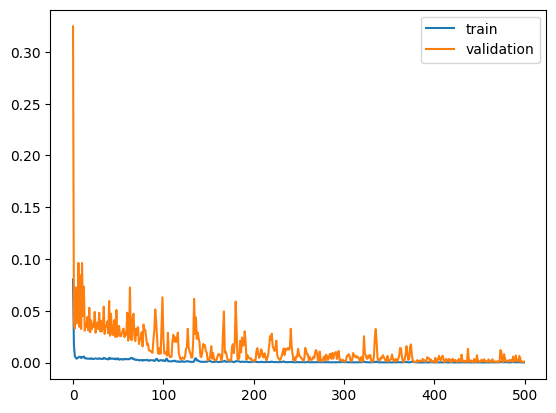

In [315]:
# 
from ml.torch.utils import EarlyStopping
np.random.seed(123)
torch.manual_seed(123)
device = torch.device('cpu')


class DNN(nn.Module):

    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        super().__init__()
        self.l1 = nn.Linear(input_dim, hidden_dim)
        self.a1 = nn.ReLU()
        # self.d1 = nn.Dropout(0.5)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.a2 = nn.ReLU()
        # self.d2 = nn.Dropout(0.5)
        self.l3 = nn.Linear(hidden_dim, hidden_dim)
        self.a3 = nn.ReLU()
        # self.d3 = nn.Dropout(0.5)
        self.l4 = nn.Linear(hidden_dim, output_dim)
        self.layers = [self.l1, self.a1, 
                       self.l2, self.a2, 
                       self.l3, self.a3,
                       self.l4]
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

n_features = scaled_df.shape[1] - 2
print(f'n_features: {n_features}')
model = DNN(input_dim=n_features, hidden_dim=n_features*2, output_dim=1).to(device)
criterion = nn.MSELoss()
# optimizer = optimizers.SGD(model.parameters(), lr=0.009)
optimizer = optimizers.Adam(model.parameters(), lr=0.005)

def compute_loss(y, yhat):
    return criterion(yhat, y)

def train_step(x, y):
    model.train()
    preds = model(x)
    loss = compute_loss(y, preds)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

def val_step(x, y):
    model.eval()
    preds = model(x)
    loss = compute_loss(y, preds)
    return loss, preds

epochs = 500
batch_size = 10
n_batches = X_train.shape[0] // batch_size
hist = {'loss': [], 'val_loss': []}

# es = EarlyStopping(patience=10, verbose=1)

for epoch in range(epochs):
    train_loss = 0.
    val_loss = 0.
    
    x_, y_ = shuffle(X_train, y_train)
    x_ = torch.Tensor(x_).to(device)
    y_ = torch.Tensor(y_).to(device)
    for n_batch in range(n_batches):
        start = n_batch * batch_size
        end = start + batch_size
        loss = train_step(x_[start:end], y_[start:end])
        train_loss += loss.item()
    train_loss /= n_batches
    
    for x_, y_ in zip(X_val, y_val):
        x_ = torch.Tensor(x_).to(device)
        y_ = torch.Tensor(y_).to(device)
        loss, _ = val_step(x_, y_)
        val_loss += loss.item()
    val_loss /= n_batches
    
    hist['loss'].append(train_loss)
    hist['val_loss'].append(val_loss)
    
    print('epoch: {}, loss: {:.3}, val_loss: {:.3}'.format(
        epoch+1,
        train_loss,
        val_loss
    ))
    
    # if es(val_loss):
    #     break
    
plt.plot(hist['loss'], label='train')
plt.plot(hist['val_loss'], label='validation')
plt.legend()

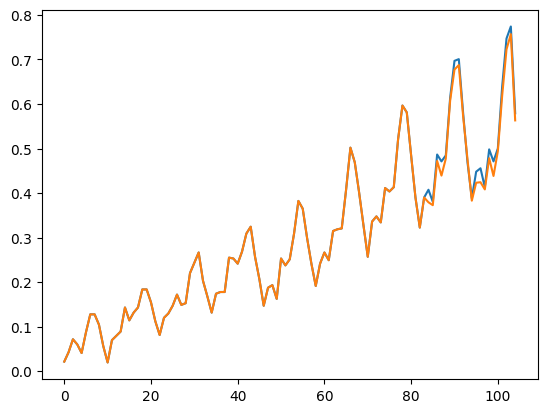

In [316]:
# 検証データの予測値をプロット
y_preds = []
for x_ in X_val:
    y_pred = model(torch.Tensor(x_).to(device))
    y_preds.append(y_pred.item())
y_preds = np.array(y_preds)


plt.plot(np.concatenate([y_train, y_val]))
plt.plot(np.concatenate([y_train, y_preds.reshape(-1,1)]))

In [323]:
train_val

,y,y_lag_1,y_lag_2,y_lag_3,y_lag_4,y_lag_5,y_lag_6,y_lag_7,y_lag_8,y_lag_9,y_lag_10,mean_6,log_y_diff,y_diff,y_diff_12,linear_time,mean_24
12,0.021236,0.027027,0.000000,0.028958,0.061776,0.084942,0.084942,0.059846,0.032819,0.048263,0.054054,0.041264,-0.241162,-0.005792,0.005792,12,0.043518
13,0.042471,0.021236,0.027027,0.000000,0.028958,0.061776,0.084942,0.084942,0.059846,0.032819,0.048263,0.037957,0.693147,0.021236,0.015444,13,0.041354
14,0.071429,0.042471,0.021236,0.027027,0.000000,0.028958,0.061776,0.084942,0.084942,0.059846,0.032819,0.038686,0.519875,0.028958,0.017375,14,0.041457
15,0.059846,0.071429,0.042471,0.021236,0.027027,0.000000,0.028958,0.061776,0.084942,0.084942,0.059846,0.043878,-0.176931,-0.011583,0.011583,15,0.044075
16,0.040541,0.059846,0.071429,0.042471,0.021236,0.027027,0.000000,0.028958,0.061776,0.084942,0.084942,0.046371,-0.389465,-0.019305,0.007722,16,0.045390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,0.500000,0.471042,0.498069,0.413127,0.455598,0.447876,0.388031,0.469112,0.579151,0.700772,0.696911,0.480437,0.059660,0.028958,0.015444,112,0.412033
113,0.638996,0.500000,0.471042,0.498069,0.413127,0.455598,0.447876,0.388031,0.469112,0.579151,0.700772,0.483232,0.245290,0.138996,0.025097,113,0.415587
114,0.747104,0.638996,0.500000,0.471042,0.498069,0.413127,0.455598,0.447876,0.388031,0.469112,0.579151,0.505484,0.156306,0.108108,0.050193,114,0.424609
115,0.774131,0.747104,0.638996,0.500000,0.471042,0.498069,0.413127,0.455598,0.447876,0.388031,0.469112,0.540001,0.035537,0.027027,0.073359,115,0.437628
